In [ ]:
!pip install -qU langchain_openai langsmith langgraph langchain numexpr langchain_community

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'
os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'

# LLMCompiler

**LLMCompiler** is an agent architecture designed to **speed up** the execution of agentic tasks by eagerly-executed tasks within a DAG. It also saves costs on redundant token usage by reducing the number of calls to the LLM.

It has 3 main components:
1. **Planner**: stream a DAG of tasks.
2. **Task Fetching Unit**: schedules and executes the tasks as soon as they are executable.
3. **Joiner**: responds to the user or trigers a second plan.

# Helper Files

## Math Tools

In [3]:
import math
import re
from typing import List, Optional

import numexpr
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import StructuredTool
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

In [4]:
_MATH_DESCRIPTION = (
    "math(problem: str, context: Optional[list[str]]) -> float:\n"
    " - Solves the provided math problem.\n"
    ' - `problem` can be either a simple math problem (e.g. "1 + 3") or a word problem (e.g. "how many apples are there if there are 3 apples and 2 apples").\n'
    " - You cannot calculate multiple expressions in one call. For instance, `math('1 + 3, 2 + 4')` does not work. "
    "If you need to calculate multiple expressions, you need to call them separately like `math('1 + 3')` and then `math('2 + 4')`\n"
    " - Minimize the number of `math` actions as much as possible. For instance, instead of calling "
    '2. math("what is the 10% of $1") and then call 3. math("$1 + $2"), '
    'you MUST call 2. math("what is the 110% of $1") instead, which will reduce the number of math actions.\n'
    # Context specific rules below
    " - You can optionally provide a list of strings as `context` to help the agent solve the problem. "
    "If there are multiple contexts you need to answer the question, you can provide them as a list of strings.\n"
    " - `math` action will not see the output of the previous actions unless you provide it as `context`. "
    "You MUST provide the output of the previous actions as `context` if you need to do math on it.\n"
    " - You MUST NEVER provide `search` type action's outputs as a variable in the `problem` argument. "
    "This is because `search` returns a text blob that contains the information about the entity, not a number or value. "
    "Therefore, when you need to provide an output of `search` action, you MUST provide it as a `context` argument to `math` action. "
    'For example, 1. search("Barack Obama") and then 2. math("age of $1") is NEVER allowed. '
    'Use 2. math("age of Barack Obama", context=["$1"]) instead.\n'
    " - When you ask a question about `context`, specify the units. "
    'For instance, "what is xx in height?" or "what is xx in millions?" instead of "what is xx?"\n'
)

In [5]:
_SYSTEM_PROMPT = """
Translate a math problem into a expression that can be executed using Python's numexpr library. Use the output of running this code to answer the question.

Question: ${{Question with math problem.}}
```text
${{single line mathematical expression that solves the problem}}
```
...numexpr.evaluate(text)...
```output
${{Output of running the code}}
```
Answer: ${{Answer}}

Begin.

Question: What is 37593 * 67?
ExecuteCode({{code: "37593 * 67"}})
...numexpr.evaluate("37593 * 67")...
```output
2518731
```
Answer: 2518731

Question: 37593^(1/5)
ExecuteCode({{code: "37593**(1/5)"}})
...numexpr.evaluate("37593**(1/5)")...
```output
8.222831614237718
```
Answer: 8.222831614237718
"""

In [6]:
_ADDITIONAL_CONTEXT_PROMPT = """
The following additional context is provided from other functions.\
    Use it to substitute into any ${{#}} variables or other words in the problem.\
    \n\n${context}\n\nNote that context variables are not defined in code yet.\
You must extract the relevant numbers and directly put them in code.
"""

In [7]:
class ExecuteCode(BaseModel):
    """The input to the numexpr.evaluate() function"""

    reasoning: str = Field(
        ...,
        description="The reasoning behind the code expression, including how context is included, if applicable.",
    )

    code: str = Field(
        ...,
        description="The simple code expression to execute by numexpr.evaluate().",
    )


def _evaluate_expression(expression: str) -> str:
    try:
        local_dict = {'pi': math.pi, 'e': math.e}

        output = str(
            numexpr.evaluate(
                expression.strip(),
                global_dict={}, # restrict access to globals
                local_dict=local_dict, # add common mathematical function
            )
        )
    except Exception as e:
        raise ValueError(
            f'Failed to evaluate "{expression}". Raise error: {repr(e)}.'
            " Please try again with a valid numerical expression."
        )

    # Remove any leading and trailing brackets from the output
    return re.sub(r"^\[|\]$", "", output)


def get_math_tool(llm: ChatOpenAI):
    prompt = ChatPromptTemplate.from_messages(
        [
            ('system', _SYSTEM_PROMPT),
            ('user', "{problem}"),
            MessagesPlaceholder(variable_name='context', optional=True),
        ]
    )

    extractor = prompt | llm.with_structured_output(ExecuteCode)

    def calculate_expression(
            problem: str,
            context: Optional[List[str]] = None,
            config: Optional[RunnableConfig] = None,
    ):
        chain_input = {'problem': problem}
        if context:
            context_str = "\n".join(context)
            if context_str.strip():
                context_str = _ADDITIONAL_CONTEXT_PROMPT.format(
                    context=context_str.strip()
                )
                chain_input['context'] = [SystemMessage(content=context_str)]

        code_model = extractor.invoke(chain_input, config)
        try:
            return _evaluate_expression(code_model.code)
        except Exception as e:
            return repr(e)

    return StructuredTool.from_function(
        name='math',
        func=calculate_expression,
        description=_MATH_DESCRIPTION,
    )

## Output Parser

In [8]:
import ast
import re
from typing import Any, Dict, Iterator, List, Optional, Sequence, Tuple, Union

from langchain_core.exceptions import OutputParserException
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers.transform import BaseTransformOutputParser
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import BaseTool

from typing_extensions import TypedDict

In [10]:
THOUGHT_PATTERN = r"Thought: ([^\n]*)"
ACTION_PATTERN = r"\n*(\d+)\. (\w+)\((.*)\)(\s*#\w+\n)?"
# $1 or ${1} -> 1
ID_PATTERN = r"\$\{?(\d+)\}?"
END_OF_PLAN = "<END_OF_PLAN>"

In [11]:
def _ast_parse(arg: str) -> Any:
    try:
        return ast.literal_eval(arg)
    except:
        return arg


def _parse_llm_compiler_action_args(args: str, tool: Union[str, BaseTool]) -> List[Any]:
    """Parse arguments from a string"""

    if args == "":
        return ()
    if isinstance(tool, str):
        return ()

    extracted_args = {}
    tool_key = None
    prev_idx = None
    for key in tool.args.keys():
        # Split if present
        if f"{key}=" in args:
            idx = args.index(f"{key}=")
            if prev_idx is not None:
                extracted_args[tool_key] = _ast_parse(args[prev_idx:idx].strip().rstrip(","))

            args = args.split(f"{key}=", 1)[1]
            tool_key = key
            prev_idx = 0

    if prev_idx is not None:
        extracted_args[tool_key] = _ast_parse(args[prev_idx:].strip().rstrip(",").rstrip(")"))

    return extracted_args


def default_dependency_rule(idx, args: str):
    matches = re.findall(ID_PATTERN, args)
    numbers = [int(match) for match in matches]
    return idx in numbers


def _get_dependencies_from_graph(
        idx: int, tool_name: str, args: Dict[str, Any]
) -> Dict[str, list[str]]:
    """Get dependencies from a graph"""
    if tool_name == 'join':
        return list(range(1, idx))

    return [i for i in range(1, idx) if default_dependency_rule(i, str(args))]



class Task(TypedDict):
    idx: int
    tool: BaseTool
    args: list
    dependencies: Dict[str, list]
    thought: Optional[str]



def instantiate_task(
        tools: Sequence[BaseTool],
        idx: int,
        tool_name: str,
        args: Union[str, Any],
        thought: Optional[str] = None,
) -> Task:
    if tool_name == 'join':
        tool = 'join'
    else:
        try:
            tool = tools[[tool.name for tool in tools].index(tool_name)]
        except ValueError as e:
            raise OutputParserException(f"Tool {tool_name} not found.") from e

    tool_args = _parse_llm_compiler_action_args(args, tool)
    dependencies = _get_dependencies_from_graph(idx, tool_name, tool_args)

    return Task(
        idx=idx,
        tool=tool,
        args=tool_args,
        dependencies=dependencies,
        thought=thought,
    )



class LLMCompilerPlanParser(BaseTransformOutputParser[dict], extra="allow"):
    """Planning output parser"""

    tools: List[BaseTool]

    def _transform(self, input: Iterator[Union[str, BaseMessage]]) -> Iterator[Task]:
        texts = []
        # TODO: Cleanup tuple state tracking here
        thought = None
        for chunk in input:
            # Assume input is str. TODO: support vision/other formats
            text = chunk if isinstance(chunk, str) else str(chunk.content)
            for task, thought in self.ingest_token(text, texts, thought):
                yield task

        # Final possible task
        if texts:
            task, _ = self._parse_task("".join(texts), thought)
            if task:
                yield task

    def parse(self, text: str) -> List[Task]:
        return list(self._transform([text]))

    def stream(
            self,
            input: str | BaseMessage,
            config: RunnableConfig | None = None,
            **kwargs: Any | None,
    ) -> Iterator[Task]:
        yield from self.transform([input], config, **kwargs)

    def ingest_token(
            self,
            token: str,
            buffer: List[str],
            thought: Optional[str],
    ) -> Iterator[Tuple[Optional[Task], str]]:
        buffer.append(token)

        if "\n" in token:
            buffer_ = "".join(buffer).split('\n')
            suffix = buffer_[-1]
            for line in buffer_[:-1]:
                task, thought = self._parse_task(line, thought)
                if task:
                    yield task, thought

            buffer.clear()
            buffer.append(suffix)

    def _parse_task(self, line: str, thought: Optional[str] = None):
        task = None

        if match := re.match(THOUGHT_PATTERN, line):
            # Optionally, action can be preceded by a thought
            thought = match.group(1)
        elif match := re.match(ACTION_PATTERN, line):
            # if action is parsed, return the task, and clear the buffer
            idx, tool_name, args, _ = match.groups()
            idx = int(idx)
            task = instantiate_task(
                tools=self.tools,
                idx=idx,
                tool_name=tool_name,
                args=args,
                thought=thought,
            )
            thought = None

        return task, thought

# Define Tools

We will give the agent the search engine and calculator tools.

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

# calculator
calculate = get_math_tool(ChatOpenAI(model='gpt-3.5-turbo'))
# search engine
search = TavilySearchResults(
    max_results=1,
    description='tavily_search_results_json(query="the search query") - a search engine.',
)

tools = [search, calculate]

In [15]:
# test if the calculator works
calculate.invoke(
    {
        'problem': "What's the temperature in Raleigh + 5?",
        'context': ['The tempearature in Raleigh is 72 degrees Fahrenheit.'],
    }
)

'77'

# Planner

The planner accepts the input question and generates a task list to execute.

If it is provided with a previous plan, it is instructed to re-plan, which is useful if, upon completion of the first batch of tasks, the agent must take more actions.

The output parser processes a task list in the following form:
```
1. tool_1(arg1="arg1", arg2=3.5, ...)
Thought: I then want to find out Y by using tool_2
2. tool_2(arg1="", args2="${1}")
3. join()<END_OF_PLAN>
```

In [16]:
from typing import Sequence

from langchain import hub
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

In [17]:
prompt = hub.pull('wfh/llm-compiler')
print(prompt.pretty_print())

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:
{tool_descriptions}
{num_tools}. join(): Collects and combines results from prior actions.

 - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
 - join should always be the last action in the plan, and will be called in two scenarios:
   (a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
   (b) if the answer cannot be determined in the planning phase before you execute the plans. Guidelines:
 - Each action described above contains input/output types and description.
    - You must strictly adhere to the input and output types for each action.
    - The action descriptions contain the guidelines. You MUST strictly follow those guideline

In [18]:
def create_planner(
        llm: BaseChatModel,
        tools: Sequence[BaseTool],
        base_prompt: ChatPromptTemplate,
):
    tool_descriptions = "\n".join(
        f"{i+1}. {tool.description}\n" for i, tool in enumerate(tools)
    )

    planner_prompt = base_prompt.partial(
        replan="",
        num_tools=len(tools)
                    +1, # because we add the 'join()' tool at the end
        tool_descriptions=tool_descriptions,
    )

    replanner_prompt = base_prompt.partial(
        replan=' - You are given "Previous Plan" which is the plan that the previous agent created along with the execution results '
        "(given as Observation) of each plan and a general thought (given as Thought) about the executed results."
        'You MUST use these information to create the next plan under "Current Plan".\n'
        ' - When starting the Current Plan, you should start with "Thought" that outlines the strategy for the next plan.\n'
        " - In the Current Plan, you should NEVER repeat the actions that are already executed in the Previous Plan.\n"
        " - You must continue the task index from the end of the previous one. Do not repeat task indices.",
        num_tools=len(tools) + 1,
        tool_descriptions=tool_descriptions,
    )

    def should_replan(state: list):
        # Context is passed as a system message
        return isinstance(state[-1], SystemMessage)

    def wrap_messages(state: list):
        return {'messages': state}

    def wrap_and_get_last_index(state: list):
        next_task = 0

        for message in state[::-1]:
            if isinstance(message, FunctionMessage):
                next_task = message.additional_kwargs['idx'] + 1
                break

        state[-1].content = state[-1].content + f" - Begin counting at: {next_task}"
        return {'messages': state}


    return (
        RunnableBranch(
        (should_replan, wrap_and_get_last_index | replanner_prompt),
        wrap_messages | planner_prompt,
        )
        | llm
        | LLMCompilerPlanParser(tools=tools)
    )

In [19]:
llm = ChatOpenAI(model='gpt-3.5-turbo')
# This is the primary agent in our application
planner = create_planner(llm, tools, prompt)

In [20]:
# Test
example_question = "What's the temperature in Raleigh raised to the 3rd power?"

for task in planner.stream([HumanMessage(content=example_question)]):
    print(task['tool'], task['args'])
    print('--------')

description='tavily_search_results_json(query="the search query") - a search engine.' max_results=1 api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')) {'query': 'temperature in Raleigh'}
--------
name='math' description='math(problem: str, context: Optional[list[str]]) -> float:\n - Solves the provided math problem.\n - `problem` can be either a simple math problem (e.g. "1 + 3") or a word problem (e.g. "how many apples are there if there are 3 apples and 2 apples").\n - You cannot calculate multiple expressions in one call. For instance, `math(\'1 + 3, 2 + 4\')` does not work. If you need to calculate multiple expressions, you need to call them separately like `math(\'1 + 3\')` and then `math(\'2 + 4\')`\n - Minimize the number of `math` actions as much as possible. For instance, instead of calling 2. math("what is the 10% of $1") and then call 3. math("$1 + $2"), you MUST call 2. math("what is the 110% of $1") instead, which will reduce the number of math acti

# Task Fetching Unit

This component schedules the tasks. It receives the stream of tools of the following format:
```
{
    tool: BaseTool,
    dependencies: number[],
}
```

The basic idea is to begin executing tools as soon as their dependencies are met. This is done through multi-threading.

In [21]:
import re
import time
from concurrent.futures import ThreadPoolExecutor, wait
from typing import Any, Dict, Iterable, List, Union
from typing_extensions import TypedDict

from langchain_core.runnables import chain as as_runnable


def _get_observations(messages: List[BaseMessage]) -> Dict[int, Any]:
    # Get all previous tool responses
    results = {}
    for message in messages[::-1]:
        if isinstance(message, FunctionMessage):
            results[int(message.additional_kwargs['idx'])] = message.content
    return results


class SchedulerInput(TypedDict):
    messages: List[BaseMessage]
    tasks: Iterable[Task]


def _execute_task(task, observations, config):
    tool_to_use = task['tool']
    if isinstance(tool_to_use, str):
        return tool_to_use

    args = task['args']
    try:
        if isinstance(args, str):
            resolved_args = _resolve_arg(args, observations)
        elif isinstance(args, dict):
            resolved_args = {
                key: _resolve_arg(val, observations) for key, val in args.items()
            }
        else:
            resolved_args = args
    except Exception as e:
        return (
            f"ERROR (Failed to call {tool_to_use.name} with args {args}.)"
            f" Args could not be resolved. Error: {repr(e)}"
        )

    try:
        return tool_to_use.invoke(resolved_args, config)
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}."
            + f" Args resolved to {resolved_args}. Error: {repr(e)})"
        )

def _resolve_arg(arg: Union[str, Any], observations: Dict[int, Any]):
    # $1 or ${1} -> 1
    ID_PATTERN = r"\$\{?(\d+)\}?"

    def replace_match(match):
        # If the string is ${123}, match.group(0) is ${123}, and match.group(1) is 123.

        # Return the match group, in this case the index, from the string. This is the index
        # number we get back.
        idx = int(match.group(1))
        return str(observations.get(idx, match.group(0)))

    # For dependencies on other tasks
    if isinstance(arg, str):
        return re.sub(ID_PATTERN, replace_match, arg)
    elif isinstance(arg, list):
        return [_resolve_arg(a, observations) for a in arg]
    else:
        return str(arg)


@as_runnable
def schedule_task(task_inputs, config):
    task: Task = task_inputs["task"]
    observations: Dict[int, Any] = task_inputs["observations"]
    try:
        observation = _execute_task(task, observations, config)
    except Exception:
        import traceback

        observation = traceback.format_exception()  # repr(e) +
    observations[task["idx"]] = observation


def schedule_pending_task(
    task: Task, observations: Dict[int, Any], retry_after: float = 0.2
):
    while True:
        deps = task["dependencies"]
        if deps and (any([dep not in observations for dep in deps])):
            # Dependencies not yet satisfied
            time.sleep(retry_after)
            continue
        schedule_task.invoke({"task": task, "observations": observations})
        break


@as_runnable
def schedule_tasks(scheduler_input: SchedulerInput) -> List[FunctionMessage]:
    """Group the tasks into a DAG schedule."""
    # For streaming, we are making a few simplifying assumption:
    # 1. The LLM does not create cyclic dependencies
    # 2. That the LLM will not generate tasks with future deps
    # If this ceases to be a good assumption, you can either
    # adjust to do a proper topological sort (not-stream)
    # or use a more complicated data structure
    tasks = scheduler_input["tasks"]
    args_for_tasks = {}
    messages = scheduler_input["messages"]
    # If we are re-planning, we may have calls that depend on previous
    # plans. Start with those.
    observations = _get_observations(messages)
    task_names = {}
    originals = set(observations)
    # ^^ We assume each task inserts a different key above to
    # avoid race conditions...
    futures = []
    retry_after = 0.25  # Retry every quarter second
    with ThreadPoolExecutor() as executor:
        for task in tasks:
            deps = task["dependencies"]
            task_names[task["idx"]] = (
                task["tool"] if isinstance(task["tool"], str) else task["tool"].name
            )
            args_for_tasks[task["idx"]] = task["args"]
            if (
                # Depends on other tasks
                deps and (any([dep not in observations for dep in deps]))
            ):
                futures.append(
                    executor.submit(
                        schedule_pending_task, task, observations, retry_after
                    )
                )
            else:
                # No deps or all deps satisfied
                # can schedule now
                schedule_task.invoke(dict(task=task, observations=observations))
                # futures.append(executor.submit(schedule_task.invoke dict(task=task, observations=observations)))

        # All tasks have been submitted or enqueued
        # Wait for them to complete
        wait(futures)
    # Convert observations to new tool messages to add to the state
    new_observations = {
        k: (task_names[k], args_for_tasks[k], observations[k])
        for k in sorted(observations.keys() - originals)
    }
    tool_messages = [
        FunctionMessage(
            name=name,
            content=str(obs),
            additional_kwargs={"idx": k, "args": task_args},
            tool_call_id=k,
        )
        for k, (name, task_args, obs) in new_observations.items()
    ]
    return tool_messages

In [22]:
import itertools


@as_runnable
def plan_and_schedule(state):
    messages = state["messages"]
    tasks = planner.stream(messages)
    # Begin executing the planner immediately
    try:
        tasks = itertools.chain([next(tasks)], tasks)
    except StopIteration:
        # Handle the case where tasks is empty.
        tasks = iter([])
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        }
    )
    return {"messages": scheduled_tasks}

# Example Plan

In [23]:
tool_messages = plan_and_schedule.invoke(
    {
        'messages': [HumanMessage(content=example_question)]
    }
)['messages']

In [24]:
tool_messages

[FunctionMessage(content="[{'url': 'https://forecast.weather.gov/MapClick.php?site=RAH&lat=35.822&lon=-78.6588', 'content': 'NWS Raleigh Winter Weather SKYWARN virtual training - Tuesday December 10, 2024 at 7pm - Free to attend - open to public ... Hazardous Weather Conditions. Hazardous Weather Outlook ; Current conditions at Raleigh / Durham, Raleigh-Durham International Airport (KRDU) Lat: 35.89°NLon: 78.78°WElev: 394ft. Fair. 30°F-1°C. Humidity: 66%: Wind'}]", additional_kwargs={'idx': 1, 'args': {'query': 'temperature in Raleigh'}}, response_metadata={}, name='tavily_search_results_json', tool_call_id=1),
 FunctionMessage(content='27000', additional_kwargs={'idx': 2, 'args': {'problem': 'what is $1 raised to the 3rd power', 'context': ['$1']}}, response_metadata={}, name='math', tool_call_id=2)]

# Joiner

Now we have the planning and initial execution done. We need a component to process these outputs and either:
1. Respond with the correct answer, or
2. Loop with a new plan.


In the original paper, this is referred to as the **"joiner"**, which is another LLM call. We will use function calling to improve parsing reliability.

In [25]:
from langchain_core.messages import AIMessage

from pydantic import BaseModel, Field


class FinalResponse(BaseModel):
    """The final response/answer"""

    response: str = Field(description="The final response/answer")


class Replan(BaseModel):
    feedback: str = Field(
        description="Analysis of the previous attempts and recommendations on what needs to be fixed."
    )


class JoinOutputs(BaseModel):
    """Decide whether to replan or whether you can return the final response"""
    thought: str = Field(
        description="The chain of thought reasoning for the selected action"
    )
    action: Union[FinalResponse, Replan]



joiner_prompt = hub.pull('wfh/llm-compiler-joiner').partial(
    examples=""
) # we can optionally add examples

llm = ChatOpenAI(model='gpt-3.5-turbo')

runnable = joiner_prompt | llm.with_structured_output(JoinOutputs)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


We will select only the most recent messages in the state, and format the output to be more useful for the planner, should the agent need to loop.

In [26]:
def _parse_joiner_output(decision: JoinOutputs) -> List[BaseMessage]:
    response = [AIMessage(content=f"Thought: {decision.thought}")]
    if isinstance(decision.action, Replan):
        return {
            "messages": response
            + [
                SystemMessage(
                    content=f"Context from last attempt: {decision.action.feedback}"
                )
            ]
        }
    else:
        return {"messages": response + [AIMessage(content=decision.action.response)]}


def select_recent_messages(state) -> dict:
    messages = state["messages"]
    selected = []
    for msg in messages[::-1]:
        selected.append(msg)
        if isinstance(msg, HumanMessage):
            break
    return {"messages": selected[::-1]}


joiner = select_recent_messages | runnable | _parse_joiner_output

In [27]:
input_messages = [HumanMessage(content=example_question)] + tool_messages

In [28]:
joiner.invoke({"messages": input_messages})

{'messages': [AIMessage(content="Thought: I have the necessary information to answer the user's question.", additional_kwargs={}, response_metadata={}),
  AIMessage(content='The temperature in Raleigh raised to the 3rd power is 27,000.', additional_kwargs={}, response_metadata={})]}

# Compose using LangGraph

We will define the agent as a stateful graph, with the main nodes being:
1. Plan and execute (the DAG from the first step above)
2. Join: determine if we should finish or replan
3. Recontextualize: update the graph state based on the output from the joiner

In [29]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 1.  Define vertices
# We defined plan_and_schedule above already
# Assign each node to a state variable to update
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("join", joiner)


## Define edges
graph_builder.add_edge("plan_and_schedule", "join")

### This condition determines looping logic


def should_continue(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage):
        return END
    return "plan_and_schedule"


graph_builder.add_conditional_edges(
    "join",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
graph_builder.add_edge(START, "plan_and_schedule")
chain = graph_builder.compile()

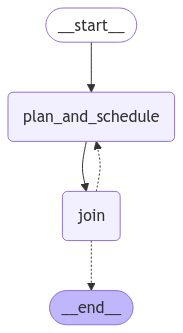

In [30]:
from IPython.display import Image, display

display(Image(
    chain.get_graph(xray=True).draw_mermaid_png(),
))

## Simple question

In [31]:
for step in chain.stream(
    {"messages": [HumanMessage(content="What's the GDP of New York?")]}
):
    print(step)
    print("---")

{'plan_and_schedule': {'messages': [FunctionMessage(content="[{'url': 'https://usafacts.org/metrics/gross-domestic-product-gdp-by-state-new-york/', 'content': 'Home New York Gross domestic product (GDP) state — New York (dollars) Adjustment Frequency Yearly In 2022 (most recent), Gross domestic product (GDP) was $2,053,179,700,000 in the United States for New York (state). This increased by $151,883,200,000 or 7.99% from 2021. Highest: $2,053,179,700,000 in 2022 Lowest: $718,814,300,000 in 1997 DOWNLOAD Data table Year    New York Sources Agency US Bureau of Economic Analysis Source Regional Economic Accounts Last updated at USAFacts     August 25, 2023 Suggested citation By state New York Search USAFacts Population Mental health Government spending Population change USAFacts is a not-for-profit, nonpartisan civic initiative making government data easy for all. Stay informed with unbiased, data-driven insights sent to your inbox weekly. Health Population Government spending Data source

In [32]:
# Final answer
print(step["join"]["messages"][-1].content)

The GDP of New York was $2,053,179,700,000 in 2022.


## Multi-hop question

Ask a question that requires the agent to perform multiple searches

In [33]:
steps = chain.stream(
    {
        "messages": [
            HumanMessage(
                content="What's the oldest parrot alive, and how much longer is that than the average?"
            )
        ]
    },
    {
        "recursion_limit": 100,
    },
)
for step in steps:
    print(step)
    print("---")

{'plan_and_schedule': {'messages': [FunctionMessage(content="[{'url': 'https://www.oldest.org/animals/parrots/', 'content': '9 Oldest Birds in the World\\n10 Rarest Parrots in the World\\n10 Rarest Birds in the World\\n7 Largest Birds of Prey in the World\\n9 Largest Flying Birds in the World\\nRelated Post\\n8 Oldest Elephants in the World\\n10 Oldest Living Dogs\\n10 Oldest Rabbits in the World\\n10 Oldest Animal Lifespans On Earth\\n8 of the Oldest Known Puggles Ever\\nLeave a comment Cancel reply\\nYour email address will not be published. It should be noted that there are no certificates that prove Charlie’s age — but given how well-known she is and how her life has been tracked throughout history, we think it’s safe to assume that there’s some credibility to her age, even if she isn’t as old as records say.\\n Brookfield Zoo\\nphoto source: Wikipedia\\nCookie was one of the more beloved and known parrots in the world thanks to his adorable antics at Chicagoland’s zoo. 3 Oldest Pa

In [34]:
# Final answer
print(step["join"]["messages"][-1].content)

Cookie, a parrot, was believed to be the oldest member of his species alive in captivity at the age of 82 in June 2015. The average lifespan of Cookie's species in captivity is around 40-60 years. Parrots, in general, can live up to 10 to 50 years or more depending on the type and conditions they live in.


## Multi-step math

In [35]:
for step in chain.stream(
    {
        "messages": [
            HumanMessage(
                content="What's ((3*(4+5)/0.5)+3245) + 8? What's 32/4.23? What's the sum of those two values?"
            )
        ]
    }
):
    print(step)

{'plan_and_schedule': {'messages': [FunctionMessage(content='3307.0', additional_kwargs={'idx': 1, 'args': {'problem': '((3*(4+5)/0.5)+3245) + 8'}}, response_metadata={}, name='math', id='cf3cbfcb-466f-4e94-ba44-125c9957ebe7', tool_call_id=1), FunctionMessage(content='7.565011820330969', additional_kwargs={'idx': 2, 'args': {'problem': '32/4.23'}}, response_metadata={}, name='math', id='8db202fe-d9cf-4837-a261-cd773dfc15fd', tool_call_id=2), FunctionMessage(content='join', additional_kwargs={'idx': 3, 'args': ()}, response_metadata={}, name='join', id='b9716615-0682-400c-9fa9-a555fa917708', tool_call_id=3)]}}
{'join': {'messages': [AIMessage(content="Thought: I have all the necessary information to answer the user's question.", additional_kwargs={}, response_metadata={}, id='aaa9b005-84a6-421d-be2c-6bd11fea9fe2'), AIMessage(content='The sum of ((3*(4+5)/0.5)+3245) + 8 is 3307.0, and the result of 32/4.23 is approximately 7.565. The sum of these two values is 3314.565.', additional_kwar

In [36]:
# Final answer
print(step["join"]["messages"][-1].content)

The sum of ((3*(4+5)/0.5)+3245) + 8 is 3307.0, and the result of 32/4.23 is approximately 7.565. The sum of these two values is 3314.565.


## Complex Replanning Example

In [37]:
for step in chain.stream(
    {
        "messages": [
            HumanMessage(
                content="Find the current temperature in Tokyo, then, respond with a flashcard summarizing this information"
            )
        ]
    }
):
    print(step)

{'plan_and_schedule': {'messages': [FunctionMessage(content="[{'url': 'https://www.timeanddate.com/weather/japan/tokyo', 'content': 'Home \\xa0 Weather \\xa0 Japan \\xa0 Tokyo Weather in Tokyo, Japan Weather 50\\xa0°F Forecast: 56 / 44\\xa0°F Wind: 10 mph ↑ from North Current Time:   Nov 19, 2024 at 2:55:59 am See more hour-by-hour weather Forecast for the next 48 hours Forecast                           ↑   N * Updated Monday, November 18, 2024 10:02:53 pm Tokyo time - Weather by CustomWeather, © 2024 66 / 53\\xa0°F Wind: 8 mph ↑ from Northwest More weather last week 52\\xa0°F 46\\xa0°F 45\\xa0°F More weather in Japan 56 / 44\\xa0°F 50 / 43\\xa0°F 62 / 49\\xa0°F 64 / 46\\xa0°F 56 / 45\\xa0°F 57 / 43\\xa0°F 57 / 44\\xa0°F Sun & Moon times precise to the second. Privacy Policy Weather'}]", additional_kwargs={'idx': 1, 'args': {'query': 'current temperature in Tokyo'}}, response_metadata={}, name='tavily_search_results_json', id='5bda7ed3-374e-4422-ae22-4b7047816844', tool_call_id=1), Fu